In [1]:
from IPython.display import clear_output

In [2]:
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-geometric==2.3.1
# !pip install torch-geometric-temporal
# clear_output()

In [3]:
import os
import pickle

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

clear_output()

In [4]:
def load_features(feat_path, dtype=np.float32):
    feat_df = pd.read_csv(feat_path)
    feat = np.array(feat_df, dtype=dtype)
    return feat


def load_adjacency_matrix(adj_path, dtype=np.float32):
    adj_df = pd.read_csv(adj_path, header=None)
    adj = np.array(adj_df, dtype=dtype)
    return adj

### Определение гиперпараметров

In [5]:
dataset = "microservices"
data_path = f"../../data/{dataset}"
# feat_path = f"{data_path}/speed.csv"
# adj_path = f"{data_path}/adj.csv"

# Для данных microservices
adj_type = "good"
service = "no"
type_data = "calls"
feat_path = f"{data_path}/{service}_fault_{type_data}.csv"
adj_path = f"{data_path}/adj_{adj_type}.csv"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

seq_len = 12
pre_len = 3

### Подготовка данных

In [6]:
def train_test_split(data, split_ratio=0.8):
    data_len = data.shape[0]
    train_size = int(data_len * split_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data


def xy_split(data: np.ndarray, seq_len: int = 12, pre_len: int = 3):
    X_data, Y_data = [], []
    
    for i in range(data.shape[0] - int(seq_len + pre_len - 1)):
        a = data[i:i + seq_len + pre_len]
        X_data.append(a[:seq_len])
        Y_data.append(a[seq_len:seq_len + pre_len])

    return np.array(X_data).transpose((0, 2, 1)), np.array(Y_data).transpose((0, 2, 1))


def normalize_data(data: np.ndarray, means: np.ndarray, stds: np.ndarray):
    normalized_data = (data - means) / stds
    return np.nan_to_num(normalized_data, 0)


def denormalize_data(normalized_data: np.ndarray, means: np.ndarray, stds: np.ndarray):
    return normalized_data * stds + means        

In [7]:
# train_data, test_data = train_test_split(data=feat)
# means = train_data.mean(axis=0)
# stds = train_data.std(axis=0)

# train_data_normalized = normalize_data(train_data, means, stds)
# test_data_normalized = normalize_data(test_data, means, stds)

# X_train, Y_train = xy_split(train_data_normalized, seq_len, pre_len)
# X_test, Y_test = xy_split(test_data_normalized, seq_len, pre_len)

### Подготовка матрицы смежности

In [8]:
def get_edge_parameters(adj_matrix):
    edges = np.nonzero(adj_matrix)
    edges = np.vstack([edges, adj_matrix[edges]])
    edge_index = edges[:2, :].astype(float)
    edge_attr = edges[2, :].astype(float)
    
    return edge_index, edge_attr

In [9]:
def get_data_loaders(data: np.ndarray, adj_matrix: np.ndarray, seq_len: int, pre_len: int):
    train_data, test_data = train_test_split(data=data)
    means = data.mean(axis=0)
    stds = data.std(axis=0)
    
    train_data_normalized = normalize_data(train_data, means, stds)
    test_data_normalized = normalize_data(test_data, means, stds)

    X_train, Y_train = xy_split(train_data_normalized, seq_len, pre_len)
    X_test, Y_test = xy_split(test_data_normalized, seq_len, pre_len)
    
    edge_index, edge_attr = get_edge_parameters(adj_matrix)
    
    train_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_train, Y_train)
    test_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_test, Y_test)
    
    return train_loader, test_loader
    

## TGCN

In [10]:
class TGCNModel(torch.nn.Module):
    def __init__(self, seq_len, pre_len, hidden_layers):
        super(TGCNModel, self).__init__()
        self.recurrent = TGCN(seq_len, hidden_layers, 1)
        self.linear = torch.nn.Linear(hidden_layers, pre_len)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [11]:
def evaluate_model(model, data_loader, device):
    loss = 0
    step = 0
    
    with torch.no_grad():
        for snapshot in data_loader:
            snapshot = snapshot.to(device)
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            loss = loss + torch.mean(torch.abs(y_hat - snapshot.y))
            step += 1
        loss = loss / (step + 1)
    
    print("Val loss MAE: {:.4f}".format(loss.item()))
    return loss.item()

### Обучение модели

In [191]:
best_model = None

def train_model(model, train_loader, test_loader, optimizer, epochs, device, pre_len):
    train_losses, val_losses = [], []
    best_val_loss = np.inf

    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        print('==========')
        if (epoch + 1) % 50 == 0:
            optimizer.param_groups[0]['lr'] *= 0.95
            print(f"lr={optimizer.param_groups[0]['lr']}")

        loss = 0
        model.train()

        for time, snapshot in enumerate(train_loader):
            snapshot = snapshot.to(device)
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            loss = loss + torch.mean(torch.abs(y_hat - snapshot.y))
        loss = loss / (time + 1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss.item())
        print("Train loss MAE: {:.4f}".format(loss.item()))

        val_loss = evaluate_model(model, test_loader, device)
        val_losses.append(val_loss)
        
        # path_save = f"../../models/{dataset}/{pre_len}/dcrnn"
        # path_save = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/tgcn"
        # if not os.path.exists(path_save):
        #     os.makedirs(path_save)
        # with open(f"{path_save}/losses.pk", "wb") as f:
        #     pickle.dump((train_losses, val_losses), f)

        if val_loss < best_val_loss:
            # torch.save(model.state_dict(), f"{path_save}/best_model.pt")
            best_model = model
            best_val_loss = val_loss
            # print(f"Model with {best_val_loss} was saved.")

    return model, train_losses, val_losses

In [192]:
def main(seq_len, pre_len, model = None):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    train_loader, test_loader = get_data_loaders(feat, adj_matrix, seq_len, pre_len)

    if not model:
        model = TGCNModel(seq_len, pre_len)
    model.to(device)

    lr = 0.001
    epochs = 200
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model, train_losses, val_losses = train_model(model, train_loader, test_loader, optimizer, epochs, device, pre_len)
    
    return model, train_losses, val_losses
    

In [193]:
# for pre_len in (3, 6, 12):
pre_len = 3
model, train_losses, val_losses = main(seq_len=12, pre_len=pre_len)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Epoch:  1
Train loss MAE: 0.7111
Val loss MAE: 0.8849
Epoch:  2
Train loss MAE: 0.7047
Val loss MAE: 0.8781
Epoch:  3
Train loss MAE: 0.6987
Val loss MAE: 0.8723
Epoch:  4
Train loss MAE: 0.6928
Val loss MAE: 0.8664
Epoch:  5
Train loss MAE: 0.6868
Val loss MAE: 0.8606
Epoch:  6
Train loss MAE: 0.6806
Val loss MAE: 0.8554
Epoch:  7
Train loss MAE: 0.6745
Val loss MAE: 0.8502
Epoch:  8
Train loss MAE: 0.6685
Val loss MAE: 0.8447
Epoch:  9
Train loss MAE: 0.6625
Val loss MAE: 0.8392
Epoch:  10
Train loss MAE: 0.6564
Val loss MAE: 0.8336
Epoch:  11
Train loss MAE: 0.6502
Val loss MAE: 0.8279
Epoch:  12
Train loss MAE: 0.6440
Val loss MAE: 0.8220
Epoch:  13
Train loss MAE: 0.6377
Val loss MAE: 0.8158
Epoch:  14
Train loss MAE: 0.6311
Val loss MAE: 0.8092
Epoch:  15
Train loss MAE: 0.6242
Val loss MAE: 0.8023
Epoch:  16
Train loss MAE: 0.6171
Val loss MAE: 0.7950
Epoch:  17
Train loss MAE: 0.6097
Val loss MAE: 0.7873
Epoch:  18
Train loss MAE: 0.6020
Val loss MAE: 0.7796
Epoch:  19
Train lo

In [179]:
# for pre_len in (3, 6, 12):
pre_len = 3
model, train_losses, val_losses = main(seq_len=12, pre_len=pre_len)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Epoch:  1
Train loss MAE: 0.6822
Val loss MAE: 0.7530
Epoch:  2
Train loss MAE: 0.6625
Val loss MAE: 0.7291
Epoch:  3
Train loss MAE: 0.6437
Val loss MAE: 0.7049
Epoch:  4
Train loss MAE: 0.6249
Val loss MAE: 0.6804
Epoch:  5
Train loss MAE: 0.6056
Val loss MAE: 0.6544
Epoch:  6
Train loss MAE: 0.5853
Val loss MAE: 0.6272
Epoch:  7
Train loss MAE: 0.5651
Val loss MAE: 0.5985
Epoch:  8
Train loss MAE: 0.5448
Val loss MAE: 0.5676
Epoch:  9
Train loss MAE: 0.5234
Val loss MAE: 0.5349
Epoch:  10
Train loss MAE: 0.5008
Val loss MAE: 0.5002
Epoch:  11
Train loss MAE: 0.4772
Val loss MAE: 0.4631
Epoch:  12
Train loss MAE: 0.4522
Val loss MAE: 0.4238
Epoch:  13
Train loss MAE: 0.4264
Val loss MAE: 0.3847
Epoch:  14
Train loss MAE: 0.4010
Val loss MAE: 0.3539
Epoch:  15
Train loss MAE: 0.3784
Val loss MAE: 0.3339
Epoch:  16
Train loss MAE: 0.3595
Val loss MAE: 0.3218
Epoch:  17
Train loss MAE: 0.3439
Val loss MAE: 0.3205
Epoch:  18
Train loss MAE: 0.3327
Val loss MAE: 0.3250
Epoch:  19
Train lo

In [29]:
# for pre_len in (3, 6, 12):
pre_len = 3
model, train_losses, val_losses = main(seq_len=12, pre_len=pre_len)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Epoch:  1
Train loss MAE: 0.7121
Val loss MAE: 0.7746
Epoch:  2
Train loss MAE: 0.7002
Val loss MAE: 0.7576
Epoch:  3
Train loss MAE: 0.6889
Val loss MAE: 0.7410
Epoch:  4
Train loss MAE: 0.6777
Val loss MAE: 0.7245
Epoch:  5
Train loss MAE: 0.6664
Val loss MAE: 0.7078
Epoch:  6
Train loss MAE: 0.6549
Val loss MAE: 0.6905
Epoch:  7
Train loss MAE: 0.6429
Val loss MAE: 0.6734
Epoch:  8
Train loss MAE: 0.6303
Val loss MAE: 0.6556
Epoch:  9
Train loss MAE: 0.6167
Val loss MAE: 0.6369
Epoch:  10
Train loss MAE: 0.6023
Val loss MAE: 0.6178
Epoch:  11
Train loss MAE: 0.5873
Val loss MAE: 0.5980
Epoch:  12
Train loss MAE: 0.5715
Val loss MAE: 0.5777
Epoch:  13
Train loss MAE: 0.5551
Val loss MAE: 0.5563
Epoch:  14
Train loss MAE: 0.5385
Val loss MAE: 0.5344
Epoch:  15
Train loss MAE: 0.5219
Val loss MAE: 0.5120
Epoch:  16
Train loss MAE: 0.5049
Val loss MAE: 0.4888
Epoch:  17
Train loss MAE: 0.4873
Val loss MAE: 0.4650
Epoch:  18
Train loss MAE: 0.4691
Val loss MAE: 0.4406
Epoch:  19
Train lo

# Генерация данных по предсказаниям

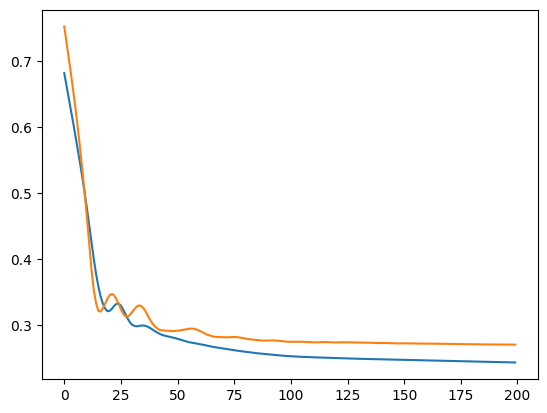

In [180]:
plt.plot(train_losses)
plt.plot(val_losses)

In [181]:
dataset = "microservices"
data_path = f"../../data/{dataset}"
adj_type = "good"
service = "no"
type_data = "calls"
feat_path = f"{data_path}/{service}_fault_{type_data}.csv"
adj_path = f"{data_path}/adj_{adj_type}.csv"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

model_type = "tgcn"
seq_len = 12
pre_len = 3

model_path = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/{model_type}"

In [182]:
train_data, test_data = train_test_split(data=feat)
means = feat.mean(axis=0)
stds = feat.std(axis=0)

_, Y_train_ground_truth = xy_split(train_data, seq_len, pre_len)
_, Y_test_ground_truth = xy_split(test_data, seq_len, pre_len)

train_loader, test_loader = get_data_loaders(feat, adj_matrix, seq_len, pre_len)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [183]:
means

array([   0.      , 1221.0236  ,  502.92126 ,  115.939865,   45.13639 ,
         61.926846, 1198.2437  ,   45.173588,  652.8252  ,   45.173588,
          0.      ,  135.52077 ], dtype=float32)

In [184]:
def get_predict_result(model, data_loader, means, stds, result_shape):
    model.eval()
    Y_preds = list()

    for snapshot in data_loader:
        y = snapshot.y.cpu().numpy()
        y_pred = model(
            snapshot.x,
            snapshot.edge_index, 
            snapshot.edge_attr,
        ).view(len(snapshot.x),-1).cpu().detach().numpy()

        y_pred = denormalize_data(y_pred, means.reshape([-1, 1]), stds.reshape([-1, 1]))
        Y_preds.extend(list(y_pred))

    Y_preds = np.array(Y_preds)
    Y_preds = Y_preds.reshape(result_shape)
    return Y_preds

In [185]:
Y_preds = get_predict_result(model=model, data_loader=test_loader, means=means, stds=stds, result_shape=Y_test_ground_truth.shape)
# np.save(f"{save_path}/{model_type}/train.npy", Y_preds)

In [186]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mean_absolute_error(Y_preds.flatten(), Y_test_ground_truth.flatten())

43.57749

In [187]:
r2_score(Y_preds.flatten(), Y_test_ground_truth.flatten())

0.9001285667487586

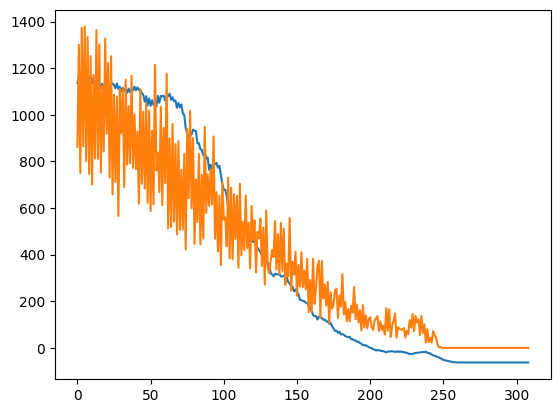

In [188]:
plt.plot(Y_preds[:, 1, 0])
plt.plot(Y_test_ground_truth[:, 1, 0])

#### metr-la, seoul

In [24]:
dataset = "metr_la"
data_path = f"../../data/{dataset}"
feat_path = f"{data_path}/speed.csv"
adj_path = f"{data_path}/adj.csv"
model_type = "tgcn"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

seq_len = 12
pre_len = 6

model_path = f"../../models/{dataset}/{pre_len}/{model_type}"

In [12]:
def read_model(model_path: str, seq_len, pre_len):
    model = TGCNModel(seq_len=seq_len, pre_len=pre_len)
    model.load_state_dict(torch.load(f"{model_path}/best_model.pt", map_location=torch.device('cpu')))
    return model

In [13]:
def get_predict_result(model, data_loader, means, stds, result_shape):
    model.eval()
    Y_preds = list()

    for snapshot in data_loader:
        y = snapshot.y.cpu().numpy()
        y_pred = model(
            snapshot.x,
            snapshot.edge_index, 
            snapshot.edge_attr,
        ).view(len(snapshot.x),-1).cpu().detach().numpy()

        y_pred = denormalize_data(y_pred, means.reshape([-1, 1]), stds.reshape([-1, 1]))
        Y_preds.extend(list(y_pred))

    Y_preds = np.array(Y_preds)
    Y_preds = Y_preds.reshape(result_shape)
    return Y_preds

In [27]:
train_data, test_data = train_test_split(data=feat)
means = feat.mean(axis=0)
stds = feat.std(axis=0)

_, Y_train_ground_truth = xy_split(train_data, seq_len, pre_len)
_, Y_test_ground_truth = xy_split(test_data, seq_len, pre_len)

train_loader, test_loader = get_data_loaders(feat, adj_matrix, seq_len, pre_len)

In [28]:
save_path = f"../../result_predict/{dataset}/{pre_len}"

np.save(f"{save_path}/ground_truth/test.npy", Y_test_ground_truth)
np.save(f"{save_path}/ground_truth/train.npy", Y_train_ground_truth)

In [29]:
model = read_model(model_path=model_path, seq_len=seq_len, pre_len=pre_len, )

In [38]:
Y_preds = get_predict_result(model=model, data_loader=train_loader, means=means, stds=stds, result_shape=Y_train_ground_truth.shape)
np.save(f"{save_path}/{model_type}/train.npy", Y_preds)

In [21]:
plt.plot(Y_preds[0:200, 100, 0])
plt.plot(Y_train_ground_truth[0:200, 100, 0])

NameError: name 'Y_preds' is not defined

In [30]:
Y_preds = get_predict_result(model=model, data_loader=test_loader, means=means, stds=stds, result_shape=Y_test_ground_truth.shape)
np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

In [31]:
Y_preds.shape

(6838, 207, 6)

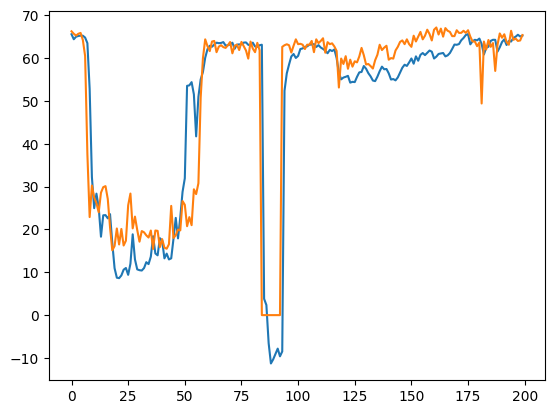

In [32]:
plt.plot(Y_preds[0:200, 100, 0])
plt.plot(Y_test_ground_truth[0:200, 100, 0])

In [ ]:
# losses = []
# with (open(f"{path_save}/losses.pk", "rb")) as openfile:
#     while True:
#         try:
#             losses.append(pickle.load(openfile))
#         except EOFError:
#             break

# train_losses = losses[0][0]
# val_losses = losses[0][1]

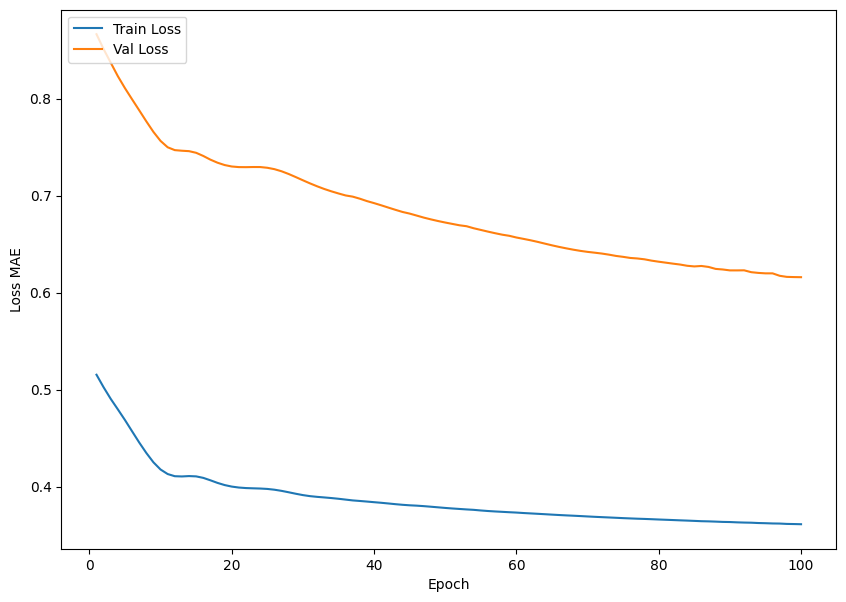

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss MAE')
plt.legend(loc="upper left")
plt.show()

#### microservices

default_data

In [63]:
dataset = "microservices"
data_path = f"../../data/{dataset}"
adj_type = "good"
service = "no"
type_data = "duration"
feat_path = f"{data_path}/{service}_fault_{type_data}.csv"
adj_path = f"{data_path}/adj_{adj_type}.csv"

feat = load_features(feat_path)
adj_matrix = load_adjacency_matrix(adj_path)

model_type = "tgcn"
seq_len = 12
pre_len = 3

model_path = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/{model_type}"

In [64]:
losses = []
with (open(f"{model_path}/losses.pk", "rb")) as openfile:
    while True:
        try:
            losses.append(pickle.load(openfile))
        except EOFError:
            break

train_losses = losses[0][0]
val_losses = losses[0][1]

In [65]:
train_data, test_data = train_test_split(data=feat)
means = feat.mean(axis=0)
stds = feat.std(axis=0)

_, Y_train_ground_truth = xy_split(train_data, seq_len, pre_len)
_, Y_test_ground_truth = xy_split(test_data, seq_len, pre_len)

train_loader, test_loader = get_data_loaders(feat, adj_matrix, seq_len, pre_len)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [66]:
save_path = f"../../result_predict/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}"

# np.save(f"{save_path}/ground_truth/test.npy", Y_test_ground_truth)
# np.save(f"{save_path}/ground_truth/train.npy", Y_train_ground_truth)

In [67]:
def read_model(model_path: str, seq_len, pre_len):
    model = TGCNModel(seq_len=seq_len, pre_len=pre_len, hidden_layers=32)
    model.load_state_dict(torch.load(f"{model_path}/best_model.pt", map_location=torch.device('cpu')))
    return model

In [68]:
model = read_model(model_path=model_path, seq_len=seq_len, pre_len=pre_len)

In [69]:
def get_predict_result(model, data_loader, means, stds, result_shape):
    model.eval()
    Y_preds = list()

    for snapshot in data_loader:
        y = snapshot.y.cpu().numpy()
        y_pred = model(
            snapshot.x,
            snapshot.edge_index, 
            snapshot.edge_attr,
        ).view(len(snapshot.x),-1).cpu().detach().numpy()

        y_pred = denormalize_data(y_pred, means.reshape([-1, 1]), stds.reshape([-1, 1]))
        Y_preds.extend(list(y_pred))

    Y_preds = np.array(Y_preds)
    Y_preds = Y_preds.reshape(result_shape)
    return Y_preds

In [70]:
Y_preds = get_predict_result(model=model, data_loader=train_loader, means=means, stds=stds, result_shape=Y_train_ground_truth.shape)
np.save(f"{save_path}/{model_type}/train.npy", Y_preds)

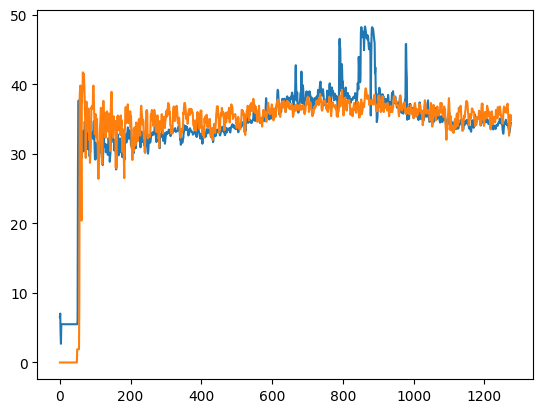

In [71]:
plt.plot(Y_preds[:, 8, 0])
plt.plot(Y_train_ground_truth[:, 8, 0])

In [72]:
Y_preds = get_predict_result(model=model, data_loader=test_loader, means=means, stds=stds, result_shape=Y_test_ground_truth.shape)
np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

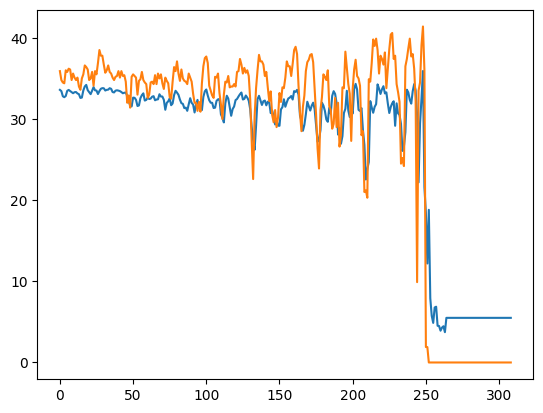

In [73]:
plt.plot(Y_preds[:, 8, 0])
plt.plot(Y_test_ground_truth[:, 8, 0])

fault data

In [74]:
for service in ("cart", "currency", "product"):
    feat_path = f"{data_path}/{service}_fault_{type_data}.csv"
    save_path = f"../../result_predict/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}"

    feat = load_features(feat_path)
    adj_matrix = load_adjacency_matrix(adj_path)
    
    _, Y_ground_truth = xy_split(feat, seq_len, pre_len)
    np.save(f"{save_path}/ground_truth/test.npy", Y_ground_truth)
    
    means = feat.mean(axis=0)
    stds = feat.std(axis=0)

    data_normalized = normalize_data(feat, means, stds)
    X_test, Y_test = xy_split(data_normalized, seq_len, pre_len)
    edge_index, edge_attr = get_edge_parameters(adj_matrix)
    test_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_test, Y_test)
    Y_preds = get_predict_result(model=model, data_loader=test_loader, means=means, stds=stds, result_shape=Y_ground_truth.shape)
    Y_preds = np.nan_to_num(Y_preds, 0)
    np.save(f"{save_path}/{model_type}/test.npy", Y_preds)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


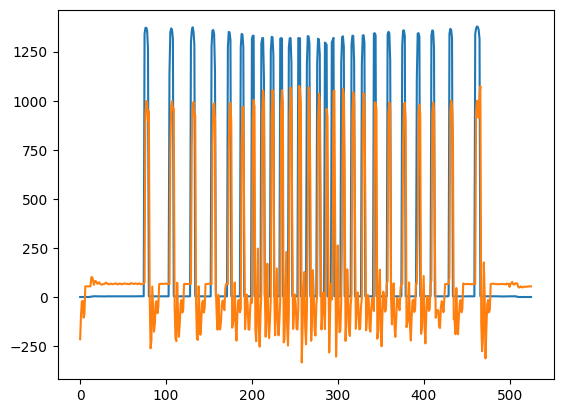

In [75]:
plt.plot(Y_ground_truth[:, 8, 0])
plt.plot(Y_preds[:, 8, 0])

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [54]:
mean_absolute_error(y_pred=Y_preds.flatten(), y_true=Y_ground_truth.flatten())

65.64263